# Path planning

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [14]:
import scipy.linalg as linalg

Just a bunch of helper methods

In [84]:
def circle(x, y, r, n=100):
    t = linspace(0, 2*pi, n)
    return r*cos(t)+x, r*sin(t)+y

def ϕ(x):
    q = np.exp(x)
    return 1/(1+q)

def dϕ(x):
    q = 1/(1+np.exp(x))
    return -q*(1-q)

A plot of what the different radii penalty look like

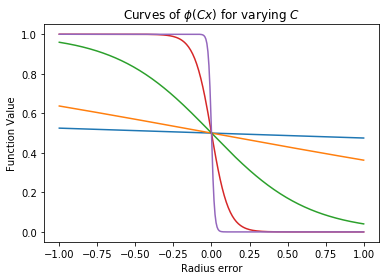

In [118]:
x = linspace(-1, 1, 300)
for l in logspace(-1, 2, 5):
    plot(x, ϕ(l*x))

title('Curves of $\phi(Cx)$ for varying $C$')
xlabel('Radius error')
ylabel('Function Value')

A simple initial test using just a circle at point $(0,0)$ with radius $1/2$

In [147]:
N_points = 100
points = np.zeros((2, N_points)) # the initial set of points
points[0,:] = np.linspace(-1, 1, N_points)

circ_pos = np.array([0, 0.1])[:,newaxis]
circ_radius2 = np.array([(1/2.)**2])

In [236]:
vec_ϕ = np.vectorize(ϕ)
vec_dϕ = np.vectorize(dϕ)

def compute_loss(curr_pos, circ_mat, circ_rad, C):
    all_dist = C*(linalg.norm(circ_mat - curr_pos, axis=0)**2/circ_radius2 - 1)
    return np.sum(ϕ(all_dist))
    
def loss(pos_mat, circ_mat, circ_rad, C):
    return np.apply_along_axis(lambda x: compute_loss(x, circ_mat, circ_rad, C), 0, pos_mat)

def compute_dloss(curr_pos, circ_mat, circ_rad, C):
    dif_mat = curr_pos[:,newaxis] - circ_mat
    all_dist = C*(linalg.norm(dif_mat, axis=0)**2/circ_radius2 - 1)
    return 2*C*np.sum(dϕ(all_dist)*dif_mat/circ_radius2, axis=1)

def dloss(pos_mat, circ_mat, circ_rad, C):
    return np.apply_along_axis(lambda x: compute_dloss(x, circ_mat, circ_rad, C), 0, pos_mat)

def complete_dloss(pos_mat, circ_mat, circ_rad, C, K):
    dloss_obstacles = dloss(pos_mat, circ_mat, circ_rad, C)[:,1:-1]
    diff_mat = -pos_mat[:,:-2] + 2*pos_mat[:,1:-1] - pos_mat[:,2:]
    zeros_mat = np.zeros(2)[:,newaxis]
    return np.c_[zeros_mat, dloss_obstacles + K*diff_mat, zeros_mat]


Plot the initial path guess

In [241]:
def plot_path(points, circles, radii, plot_title=''):
    plot(points[0,:], points[1,:], '-')
    for idx in range(len(radii)):
        curr_cirlce = circle(circles[0, idx], circles[1, idx], radii[idx])
        plot(curr_cirlce[0], curr_cirlce[1], 'r')
        
    gca().set_aspect('equal')
    title(plot_title)
    xlim(-1, 1)
    ylim(-.7, .7)

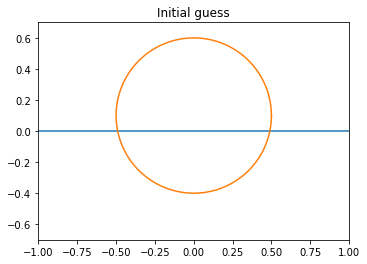

In [183]:
plot_path(points, circ_pos, sqrt(circ_radius2), 'Initial guess')

Optimize that ish

In [223]:
MAX_ITER = 500
INIT_STEP_SIZE = 1e-1
COOLING_SCHEDULE = 1.005
INIT_CONSTRAINT_HARDNESS = 10

curr_pos = copy(points)
constraint_hardness = INIT_CONSTRAINT_HARDNESS

count = 0

for i in range(MAX_ITER+1):
    curr_pos -= INIT_STEP_SIZE*dloss(curr_pos, circ_pos, circ_radius2, constraint_hardness)
    constraint_hardness *= COOLING_SCHEDULE
    
    if i%5==0:
        plot_path(curr_pos, circ_pos, sqrt(circ_radius2), 'Iteration: {}'.format(i))
        savefig('simple_step/iter{:02d}.png'.format(count))
        close()
        count += 1
        

KeyboardInterrupt: 

In [264]:
%%timeit

MAX_ITER = 5000
INIT_STEP_SIZE = 2e-3
COOLING_SCHEDULE = 1.001
INIT_CONSTRAINT_HARDNESS = 1
INIT_SPRING_HARDNESS = 100

curr_pos = copy(points)
constraint_hardness = INIT_CONSTRAINT_HARDNESS

circ_pos = array([[-.5, .1], [-.15, -.5], [.25, .25], [.5, -.05], [-.25, .5]]).T
circ_radius2 = array([.2, .4, .25, .2, .25])**2

count = 0
curr_step = INIT_STEP_SIZE


for i in range(MAX_ITER+1):
    proposed_pos = curr_pos - INIT_STEP_SIZE*complete_dloss(curr_pos, circ_pos, circ_radius2, constraint_hardness, INIT_SPRING_HARDNESS)
    
    constraint_hardness *= COOLING_SCHEDULE
    
#     if i%10==0:
#         plot_path(curr_pos, circ_pos, sqrt(circ_radius2), 'Iteration: {}'.format(i))
#         savefig('spring_step_complex_attempt_long/iter{:02d}.png'.format(count))
#         close()
#         count += 1
#         print('On iteration {}'.format(i+1))
        

/Users/Guille/Documents/Stanford/Personal/AUVSI/path-planning/venv/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


25 s ± 568 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
